In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Weather.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (39260, 7)

DATASET OVERVIEW
        date      time  temperature  pressure   humidity  label  type
0  25-Apr-19  17:33:16    40.881866 -0.101806  38.363631      1  ddos
1  25-Apr-19  17:33:16    44.913806  2.661616  46.141423      1  ddos
2  25-Apr-19  17:33:16    38.295822 -2.438871  50.850643      1  ddos
3  25-Apr-19  17:33:21    41.306586 -0.101806  38.363631      1  ddos
4  25-Apr-19  17:33:21    44.903178  3.080849  46.141423      1  ddos
5  25-Apr-19  17:33:21    38.744069 -2.438871  50.850643      1  ddos
6  25-Apr-19  17:33:31    41.507741 -0.551381  36.695085      1  ddos
7  25-Apr-19  17:33:31    44.972845  3.080849  46.890626      1  ddos
8  25-Apr-19  17:33:31    38.987172 -2.438871  46.592192      1  ddos
9  25-Apr-19  17:33:36    41.507741 -0.551381  36.695085      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39260 entries, 0 to 39259
Data columns (total 7 columns):
 #   Column       Non-Null Count  


DATA EXPLORATION
Data Types:
date            object
time            object
temperature    float64
pressure       float64
humidity       float64
label            int64
type            object
dtype: object

Descriptive Statistics:
        temperature      pressure      humidity
count  39260.000000  39260.000000  39260.000000
mean      35.243690      0.834950     47.494834
std        7.981171      3.186265     29.326872
min       20.527012    -12.065426      0.278928
25%       28.903332      0.119504     19.824197
50%       35.909279      1.035000     45.472256
75%       41.396272      1.835559     74.171240
max       49.983877     12.487613     99.875982

Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2865
xss             866
scanning        529
Name: count, dtype: int64


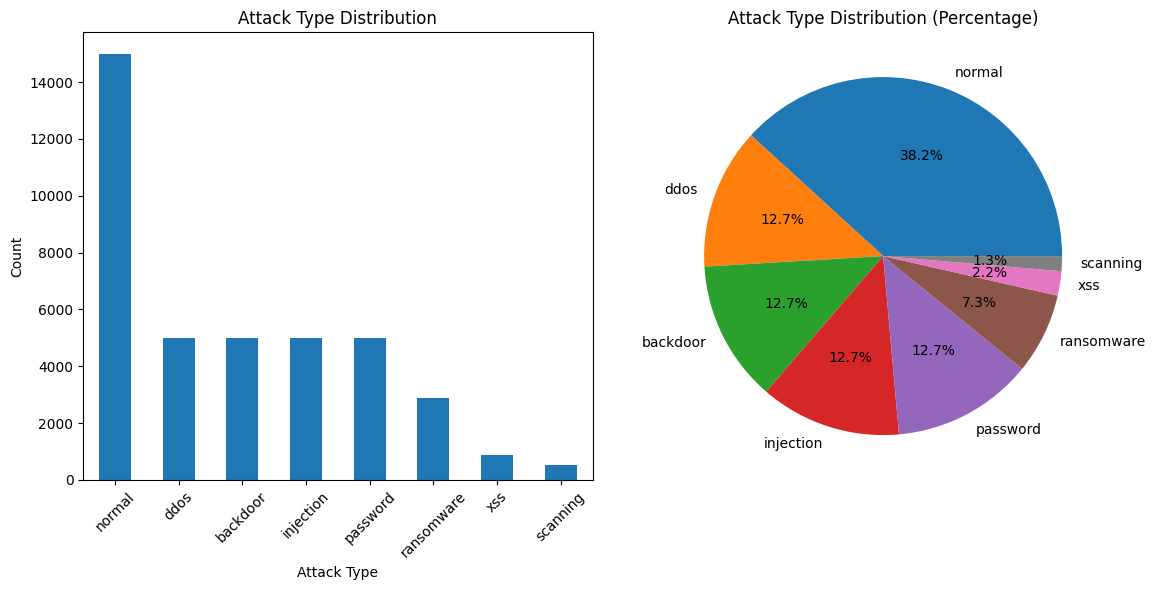

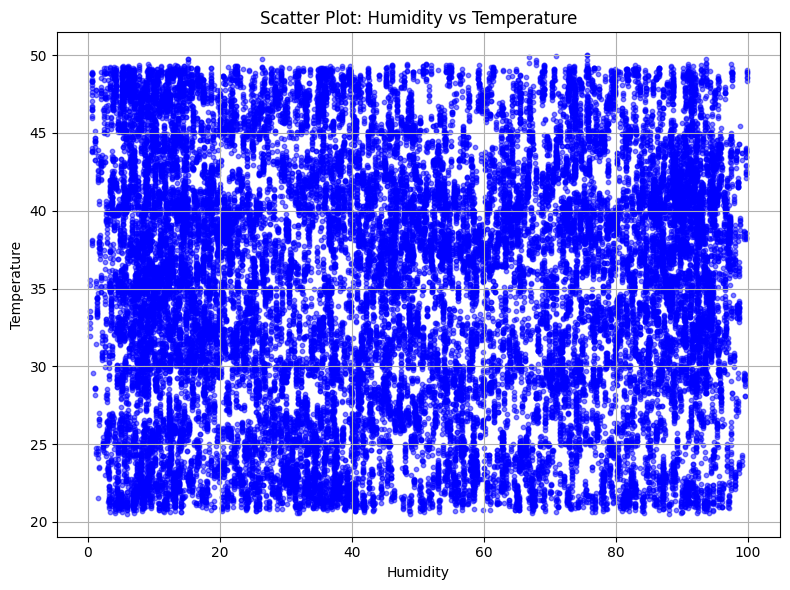

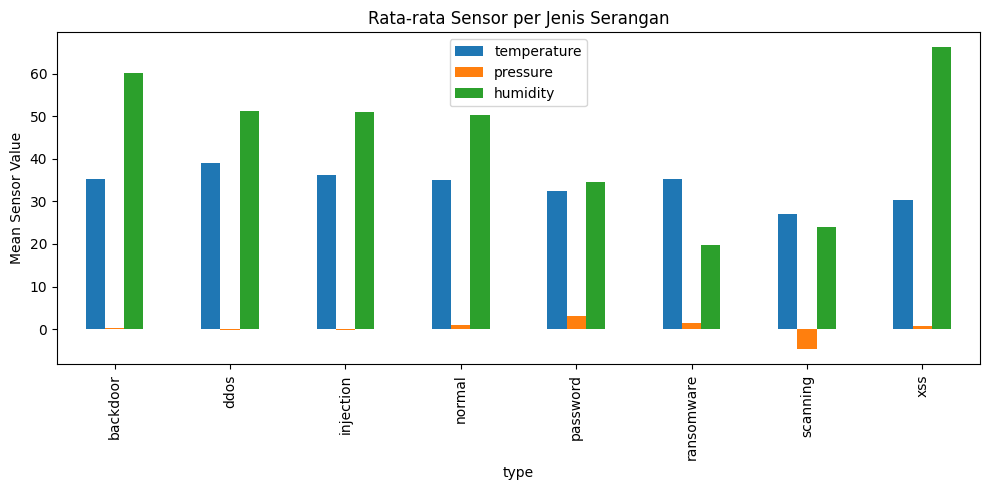

In [3]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Cek tipe data
print("Data Types:")
print(df.dtypes)

# Statistik deskriptif untuk fitur numerik
print("\nDescriptive Statistics:")
print(df[['temperature', 'pressure', 'humidity']].describe())

# Distribusi label serangan
print(f"\nAttack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualisasi distribusi jenis serangan
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
attack_distribution.plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
attack_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Scatter plot antara humidity dan temperature
plt.figure(figsize=(8, 6))
plt.scatter(df['humidity'], df['temperature'], c='blue', alpha=0.5, s=10)
plt.title('Scatter Plot: Humidity vs Temperature')
plt.xlabel('Humidity')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'humidity_vs_temperature.png'), dpi=300, bbox_inches='tight')
plt.show()

# Analisis hubungan antara serangan dan rata-rata nilai sensor
sensor_mean_by_type = df.groupby('type')[['temperature', 'pressure', 'humidity']].mean()
sensor_mean_by_type.plot(kind='bar', figsize=(10, 5))
plt.title('Rata-rata Sensor per Jenis Serangan')
plt.ylabel('Mean Sensor Value')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'sensor_mean_by_type.png'), dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Implementasi Kalman Filter
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [5]:
df_filtered = df.copy()
df_filtered['temperature'] = apply_kalman_filter(df['temperature'])
df_filtered['pressure'] = apply_kalman_filter(df['pressure'])
df_filtered['humidity'] = apply_kalman_filter(df['humidity'])

In [6]:
# ================================
# FEATURE ENGINEERING 
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabungkan kolom date dan time menjadi datetime
df_processed['datetime'] = pd.to_datetime(
    df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
    format='%d-%b-%y %H:%M:%S',
    errors='coerce'
)

# Urutkan berdasarkan waktu
df_processed = df_processed.sort_values('datetime')

# Ekstraksi fitur waktu
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Selisih waktu antar baris (dalam detik)
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# ============================================
# Temperature Dynamics Features (Sensor Basis)
# ============================================
win = 10  # ukuran jendela rolling

df_processed['temp_roll_mean'] = df_processed['temperature'].rolling(window=win, min_periods=1).mean()
df_processed['temp_roll_std'] = df_processed['temperature'].rolling(window=win, min_periods=1).std().fillna(0)
df_processed['temp_roll_range'] = (
    df_processed['temperature'].rolling(window=win, min_periods=1).max() -
    df_processed['temperature'].rolling(window=win, min_periods=1).min()
)

# Perubahan suhu
df_processed['temp_diff'] = df_processed['temperature'].diff().fillna(0)
df_processed['temp_velocity'] = df_processed['temp_diff'] / df_processed['time_diff'].replace(0, 1e-6)
df_processed['temp_acceleration'] = df_processed['temp_velocity'].diff().fillna(0) / df_processed['time_diff'].replace(0, 1e-6)

# Deteksi stabilitas
df_processed['temp_zscore'] = (df_processed['temperature'] - df_processed['temp_roll_mean']) / df_processed['temp_roll_std'].replace(0, 1e-6)
df_processed['is_temp_anomaly'] = (np.abs(df_processed['temp_zscore']) > 3).astype(int)

# ============================================
# Advanced Signal Features (Suhu)
# ============================================
from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

def dominant_freq(arr, sr=1.0):
    if len(arr) < 3:
        return 0.0
    yf = np.abs(rfft(arr - np.mean(arr)))
    xf = rfftfreq(len(arr), d=1/sr)
    if len(yf) < 2:
        return 0.0
    idx = np.argmax(yf[1:]) + 1
    return xf[idx]

def signal_entropy(arr):
    if len(arr) < 2:
        return 0.0
    hist, _ = np.histogram(arr, bins=10, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

df_processed['temp_dom_freq'] = df_processed['temperature'].rolling(window=win, min_periods=3).apply(lambda x: dominant_freq(x.values, sr=1), raw=False).fillna(0)
df_processed['temp_entropy'] = df_processed['temperature'].rolling(window=win, min_periods=2).apply(signal_entropy, raw=False).fillna(0)

# ============================================
# Interaction Features (Pressure & Humidity)
# ============================================
df_processed['pressure_x_humidity'] = df_processed['pressure'] * df_processed['humidity']
df_processed['temp_x_pressure'] = df_processed['temperature'] * df_processed['pressure']
df_processed['temp_x_humidity'] = df_processed['temperature'] * df_processed['humidity']

# ============================================
# Summary
# ============================================
new_features = [col for col in df_processed.columns if col not in df_filtered.columns]
print(f"Added {len(new_features)} new features: {new_features}")


FEATURE ENGINEERING
Added 24 new features: ['datetime', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'time_diff', 'temp_roll_mean', 'temp_roll_std', 'temp_roll_range', 'temp_diff', 'temp_velocity', 'temp_acceleration', 'temp_zscore', 'is_temp_anomaly', 'temp_dom_freq', 'temp_entropy', 'pressure_x_humidity', 'temp_x_pressure', 'temp_x_humidity']


In [7]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39260 entries, 18116 to 1397
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 39260 non-null  object        
 1   time                 39260 non-null  object        
 2   temperature          39260 non-null  float64       
 3   pressure             39260 non-null  float64       
 4   humidity             39260 non-null  float64       
 5   label                39260 non-null  int64         
 6   type                 39260 non-null  object        
 7   datetime             39260 non-null  datetime64[ns]
 8   hour                 39260 non-null  int32         
 9   minute               39260 non-null  int32         
 10  second               39260 non-null  int32         
 11  day_of_week          39260 non-null  int32         
 12  is_weekend           39260 non-null  int32         
 13  hour_sin             39260 non-nu

In [8]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [9]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39260 entries, 18116 to 1397
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 39260 non-null  object        
 1   time                 39260 non-null  object        
 2   temperature          39260 non-null  float64       
 3   pressure             39260 non-null  float64       
 4   humidity             39260 non-null  float64       
 5   label                39260 non-null  int64         
 6   type                 39260 non-null  object        
 7   datetime             39260 non-null  datetime64[ns]
 8   hour                 39260 non-null  int32         
 9   minute               39260 non-null  int32         
 10  second               39260 non-null  int32         
 11  day_of_week          39260 non-null  int32         
 12  is_weekend           39260 non-null  int32         
 13  hour_sin             39260 non-nu

In [10]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Prepare features and target
X = df_processed.copy()
X.drop(['date','time','datetime','type','label','is_temp_anomaly'], axis=1, inplace=True)
y = df_processed['type'].copy()


# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Features shape after imputation: {X_imputed.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("Data scaling completed!")
print(f"Scaled features shape: {X_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(label_encoder_target, f)

print(f"Target classes: {label_encoder_target.classes_}")
print(f"Target shape: {y_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape after imputation: (39260, 25)
Data scaling completed!
Scaled features shape: (39260, 25)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target shape: (39260,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [12]:
y_cat = to_categorical(y_encoded)

In [13]:
print(X_scaled.info())
print('\n',y_encoded.shape)
print('\n',y_encoded[:10])
print('\n',y_cat.shape)
print('\n',y_cat[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39260 entries, 0 to 39259
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature          39260 non-null  float64
 1   pressure             39260 non-null  float64
 2   humidity             39260 non-null  float64
 3   hour                 39260 non-null  float64
 4   minute               39260 non-null  float64
 5   second               39260 non-null  float64
 6   day_of_week          39260 non-null  float64
 7   is_weekend           39260 non-null  float64
 8   hour_sin             39260 non-null  float64
 9   hour_cos             39260 non-null  float64
 10  min_sin              39260 non-null  float64
 11  min_cos              39260 non-null  float64
 12  time_diff            39260 non-null  float64
 13  temp_roll_mean       39260 non-null  float64
 14  temp_roll_std        39260 non-null  float64
 15  temp_roll_range      39260 non-null 

In [14]:
# ================================
# SELEKSI FITUR GA
# ================================

# Split data validasi untuk fitness eval
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_encoded)

# --- Parameters GA ---
POP_SIZE = 20
N_GENERATIONS = 10
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X.shape[1]

# --- Fungsi buat model LSTM ---
def create_lstm_model(input_shape, n_classes):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# --- Fungsi fitness ---
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    X_train_sub = X_train.iloc[:, selected_features].values
    X_val_sub = X_val.iloc[:, selected_features].values

    # reshape to 3D
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=y_cat.shape[1])
    model.fit(X_train_sub, y_train, epochs=3, batch_size=64, verbose=0)

    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)
    y_true = np.argmax(y_val, axis=1)
    acc = accuracy_score(y_true, y_pred)

    return acc,

# --- GA tools ---
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)  # ambil akurasi dari tuple
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# --- Main GA Loop ---
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    
    # Ekstrak nilai fitness dari tuple
    accs = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(accs):.4f} | Avg fitness: {np.mean(accs):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    # evaluasi populasi baru
    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# --- Evaluasi akhir ---
accs = [fit[0] for fit in fitnesses]
best_idx = np.argmax(accs)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n--- Hasil Seleksi Fitur GA ---")
print("Selected Features Indexes:", selected_features)
print("Best Fitness (Accuracy): {:.4f}".format(accs[best_idx]))


Generation 1/10
 Best fitness: 0.9878 | Avg fitness: 0.9407

Generation 2/10
 Best fitness: 0.9916 | Avg fitness: 0.9600

Generation 3/10
 Best fitness: 0.9875 | Avg fitness: 0.9597

Generation 4/10
 Best fitness: 0.9911 | Avg fitness: 0.9593

Generation 5/10
 Best fitness: 0.9941 | Avg fitness: 0.9759

Generation 6/10
 Best fitness: 0.9915 | Avg fitness: 0.9707

Generation 7/10
 Best fitness: 0.9913 | Avg fitness: 0.9696

Generation 8/10
 Best fitness: 0.9926 | Avg fitness: 0.9821

Generation 9/10
 Best fitness: 0.9945 | Avg fitness: 0.9728

Generation 10/10
 Best fitness: 0.9940 | Avg fitness: 0.9790

--- Hasil Seleksi Fitur GA ---
Selected Features Indexes: [1, 2, 3, 5, 6, 8, 9, 10, 12, 13, 15, 18, 20, 21, 22, 24]
Best Fitness (Accuracy): 0.9926


In [15]:
selected_feature_names = [X_scaled.columns[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['pressure', 'humidity', 'hour', 'second', 'day_of_week', 'hour_sin', 'hour_cos', 'min_sin', 'time_diff', 'temp_roll_mean', 'temp_roll_range', 'temp_acceleration', 'temp_dom_freq', 'temp_entropy', 'pressure_x_humidity', 'temp_x_humidity']


In [16]:
X_selected = X_scaled.iloc[:, selected_features]
print(X_selected.shape)
print(X_selected.info())
print(X_selected.head())

(39260, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39260 entries, 0 to 39259
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pressure             39260 non-null  float64
 1   humidity             39260 non-null  float64
 2   hour                 39260 non-null  float64
 3   second               39260 non-null  float64
 4   day_of_week          39260 non-null  float64
 5   hour_sin             39260 non-null  float64
 6   hour_cos             39260 non-null  float64
 7   min_sin              39260 non-null  float64
 8   time_diff            39260 non-null  float64
 9   temp_roll_mean       39260 non-null  float64
 10  temp_roll_range      39260 non-null  float64
 11  temp_acceleration    39260 non-null  float64
 12  temp_dom_freq        39260 non-null  float64
 13  temp_entropy         39260 non-null  float64
 14  pressure_x_humidity  39260 non-null  float64
 15  temp_x_humidity      392


CORRELATION ANALYSIS


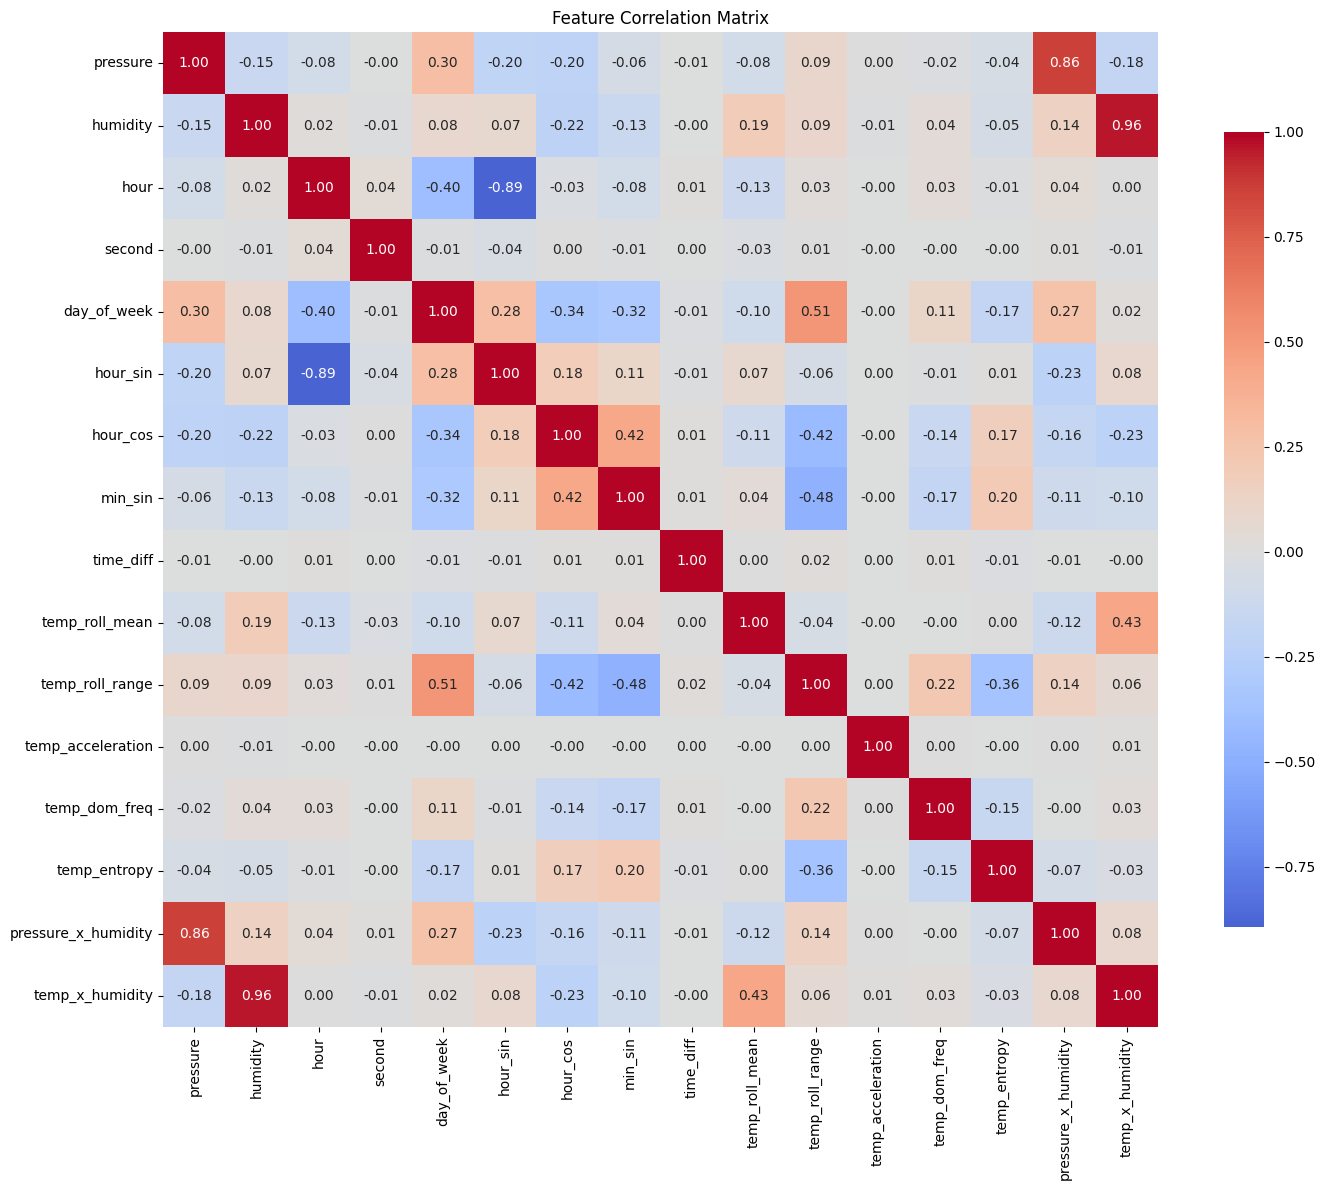

In [17]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

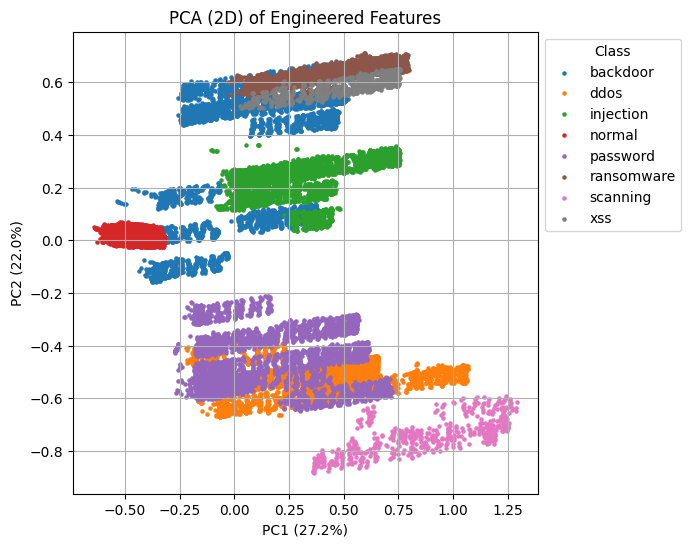

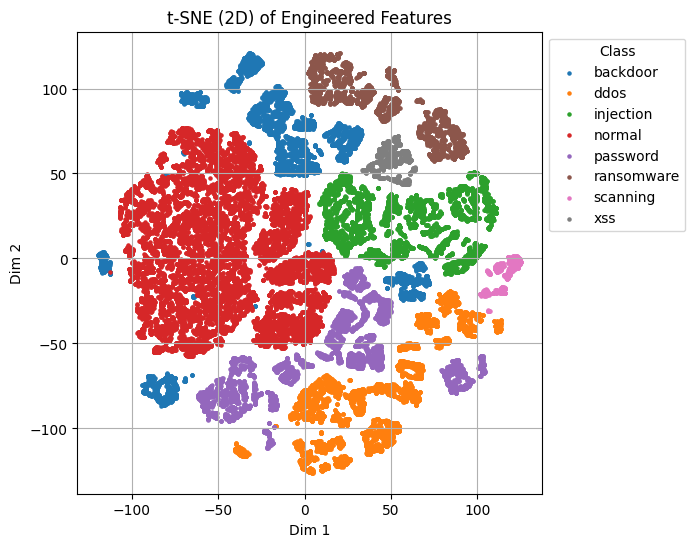

In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [19]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y.astype(str)
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [20]:
with open(os.path.join(artifacts_dir, 'data_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_selected, y_encoded), f)
    
# Simpan ke file CSV
# Pastikan X_scaled adalah array 2D dan y_encoded 1D (atau sesuai bentuk)
df = pd.DataFrame(X_selected)
df['label'] = np.array(y_encoded)

csv_path = os.path.join(artifacts_dir, 'data_preprocessing.csv')
df.to_csv(csv_path, index=False)